# Risk Aversion

We load a few modules...

In [1]:
import numpy as np
from matplotlib import pyplot as plt

## Utility function

We will user the CRRA utility function: 
$$ u(c) = \frac{c^{1-\sigma}-1}{1-\sigma} $$

In [2]:
def crra(c,sigma):
    if sigma==1.0:
        return np.log(c)
    else :
        return (c**(1-sigma)-1.0)/(1.0-sigma)



We will also create the inverse:

In [3]:
def invcrra(u,gamma):
    if sigma==1.0:
        return np.exp(w)
    else :
        return (u*(1.0-gamma)+1.0)**(1.0/(1.0-gamma))



Let's look how this function behaves...

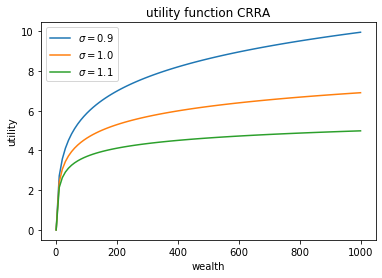

In [4]:
ws = np.linspace(1,1e3,100)
sigmas = [0.9,1.0,1.1]
plt.figure()
for sigma in sigmas:
    plt.plot(ws,crra(ws,sigma),label='$\\sigma=$'+str(sigma))
plt.xlabel('wealth')
plt.ylabel('utility')
plt.title('utility function CRRA')
plt.legend()
plt.show()


## Managing Risk

In [22]:
from scipy.stats import gamma, norm, uniform

In [23]:
F = gamma(0.5,loc=5e2,scale=1e3)

In [24]:
L = F.rvs(1000)

In [25]:
np.mean(L),np.std(L)

(1011.0427850338787, 726.2596656326696)

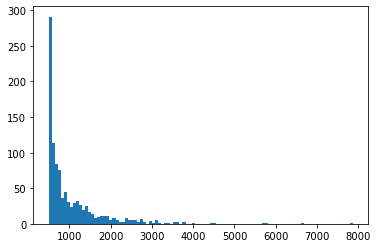

In [26]:
plt.figure()
plt.hist(L,bins=100)
plt.show()

### Expected utility (using simulations)

In [27]:
S = 10000
sig = 1000
sigma = 0.5
eps = norm(0,sig).rvs(S)
wealth = 50e3
eu = np.mean([crra(wealth+e,sigma) for e in eps])
eu

445.2054590300571

In [28]:
def eucrra(wealth,sigma,eps):
    return np.mean([crra(wealth+e,sigma) for e in eps])

In [29]:
eucrra(wealth,sigma,eps)

445.2054590300571

## Willingness to pay to eliminate risk (risk premium)

We can find the risk premium $\pi$ such that : 
$$ u(w-\pi) - Eu(w+\epsilon) = 0$$

We use bisection to find the solution

In [30]:
def solve(pi,wealth,sigma,eps):
    u = crra(wealth-pi,sigma)
    eu = eucrra(wealth,sigma,eps)
    return eu-u 

In [31]:
from scipy.optimize import bisect
S = 10000
sig = 1000.0
eps = norm(0,1).rvs(S)
wealth = 20e3
bisect(solve, 0.0, 0.95*wealth,args=(wealth,sigma,sig*eps))


19.787311686557008

The consumer is willing to pay this in order to avoid the risk altogether...

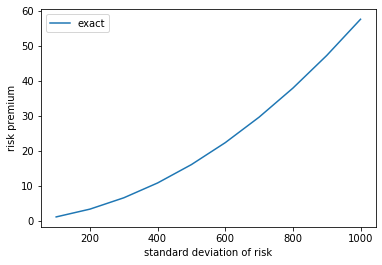

In [32]:
pis = []
sigs = np.linspace(100.0,1000.0,10)
sigma = 2.0
for sig in sigs:
    pis.append(bisect(solve, 0.0, wealth*0.95, args=(wealth,sigma,sig*eps)))
plt.figure()
plt.plot(sigs,pis,label='exact')
plt.xlabel('standard deviation of risk')
plt.ylabel('risk premium')
plt.legend()

## Exemple: Willingness to pay for a car insurance

Assume a car has a value of 50,000\$. Your insurance company is offering a policy with a deductible of 500\$ for a premium of 400\$. Your probability of an accident is 5/100. If there is an accident, the repair cost is Gamma distributed with parameter 0.5, location of 500 et scale of 1000. 
 

Let's first analyze the risk. What is the expected loss?

In [44]:

wealth = 50e3
a = 5e3
p = 0.05
S = 10000
F = gamma(0.5,loc=5e3,scale=1e3)
Lc = F.rvs(S)
Lc = np.where(Lc>wealth,wealth*0.99,Lc)
u = uniform(0,1).rvs(S)
eps = np.where(u<p,1.0,0.0)
L = np.multiply(Lc,eps)

In [45]:
np.mean(Lc),np.std(Lc),np.max(Lc)

(5504.240943538107, 709.3636091037366, 11847.73781184294)

In [46]:
np.mean(L),np.std(L),np.max(L)

(287.9499193026744, 1232.294422471638, 8718.024396400182)

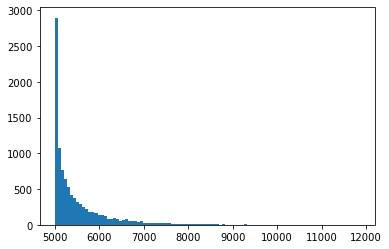

In [47]:
plt.figure()
plt.hist(Lc,bins=100)
plt.show()

In [67]:
d = 500.0
prime = 300
I = np.where((L - d)>0,L-d,0.0)
np.mean(I)

261.6999193026744

The insurer is selling the policy for 300 while the zero-profit premium would be roughly 260. So he is making a profit on that insurance. Do you purchase it? It will depend on risk aversion.

We compute his willingness to pay

In [51]:
def solve(wtp,wealth,sigma,L,I):
    eu_n = eucrra(wealth,sigma,-L)
    eu_i = eucrra(wealth-wtp,sigma,-L+I)
    return eu_i-eu_n

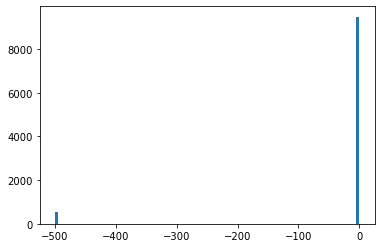

In [52]:
plt.figure()
plt.hist(-L+I,bins=100)

plt.show()

In [54]:
solve(0.0,wealth,sigma,L,I)

1.1902442620392861e-07

In [57]:
sigma = 3.0
bisect(solve, 0.0, 1000.0,args=(wealth,sigma,L,I))

314.300537109375

You are willing to pay more than the premium. So you purchase it. 

We can do it for various values of risk aversion:

In [63]:
sigmas = np.linspace(1.1,3.0,25)
wtps = []
for sigma in sigmas:
    opt = bisect(solve, 0.0, 5e3,args=(wealth,sigma,L,I))
    wtps.append(opt)

In [66]:
prime

280

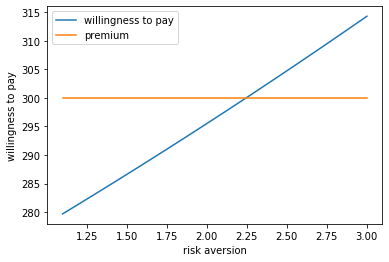

In [68]:
plt.figure()
plt.plot(sigmas,wtps,label='willingness to pay')
plt.plot(sigmas,prime*np.ones(len(sigmas)),label='premium')
plt.xlabel('risk aversion')
plt.ylabel('willingness to pay')
plt.legend()
plt.show()

An individual with a low risk aversion should not purchase. We could use a framework like this to study complex insurance products.